# Developing NIDS on normal dataset

To demonstrate the impact of adversarial attacks generated by our tool (NRT), we first train various machine learning-based Network Intrusion Detection Systems (NIDS) on a processed dataset file. Four distinct PCAPs—benign, dos_syn, ddos_icmp, and SQL injection—were processed using our UMNIDS tool to create a file named normal_data.csv. This file includes the processed flow, payload, and labels provided with the dataset.

In [1]:
import pandas as pd
df=pd.read_csv('C:\\Users\\syedwali\\Downloads\\adversarial\\normal_data.csv')

C:\Users\syedwali\AppData\Local\Temp\ipykernel_32524\3285948799.py:2: DtypeWarning: Columns (81,82,83,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('C:\\Users\\syedwali\\Downloads\\adversarial\\normal_data.csv')


In [2]:
df['label'].value_counts()

label
dos_syn      66201
benign       14892
sqli          2755
ddos_icmp      433
Name: count, dtype: int64

In [3]:
df = df[df['label'].isin(['benign', 'dos_syn','ddos_icmp'])]
df['label'] = df['label'].map({'benign': 0, 'dos_syn': 1,'ddos_icmp':2})

In [4]:
# Step 1: Get the count of instances per class
target_instances = 2500
# Step 2: Undersample or oversample each class to have exactly 2500 instances
balanced_df = pd.DataFrame()  # Empty dataframe to store balanced data

for label in df['label'].unique():
    class_subset = df[df['label'] == label]
    
    # If class has more than 2500 instances, undersample
    if len(class_subset) > target_instances:
        class_subset = class_subset.sample(target_instances, random_state=42)
    # Append the balanced class subset to the balanced dataframe
    balanced_df = pd.concat([balanced_df, class_subset])

# Reset index of the final balanced dataframe
df = balanced_df.reset_index(drop=True)
print(df['label'].value_counts())
# Now balanced_df contains 2500 instances per class in df['label']


label
0    2500
1    2500
2     433
Name: count, dtype: int64


## Flow-based NIDS

In [5]:
df.drop(['id','expiration_id','src_ip','src_mac','src_oui','src_port','dst_ip','dst_mac','dst_oui','dst_port',
'protocol','ip_version','vlan_id','tunnel_id','bidirectional_first_seen_ms','bidirectional_last_seen_ms','src2dst_first_seen_ms',
         'src2dst_last_seen_ms','dst2src_first_seen_ms','dst2src_last_seen_ms','application_name',
'application_category_name','application_is_guessed','application_confidence','requested_server_name','client_fingerprint',
'server_fingerprint','user_agent','content_type','udps.payload_data','udps.delta_time','udps.packet_direction','udps.ip_size',
'udps.transport_size','udps.payload_size','udps.syn','udps.cwr','udps.ece','udps.urg','udps.ack','udps.psh','udps.rst','udps.fin','file'],
        axis=1,inplace=True)
df.dropna(inplace=True)

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Assuming df is already defined and has a 'label' column
X = df.drop('label', axis=1)  # Features (drop the label column)
y = df['label']  # Labels

# Split the data (50% train, 50% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

# Initialize the Random Forest Classifier
clf_flow_with_context = RandomForestClassifier(n_estimators=100, random_state=42,n_jobs=-1)

# Train the classifier
clf_flow_with_context.fit(X_train, y_train)

# Predict on the test set
y_pred = clf_flow_with_context.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)

print(f'Accuracy: {accuracy:.5f}')
print('Classification Report:')
print(report)

Accuracy: 0.99485
Classification Report:
              precision    recall  f1-score   support

           0     0.9914    1.0000    0.9957      1273
           1     0.9984    0.9967    0.9976      1227
           2     0.9952    0.9539    0.9741       217

    accuracy                         0.9948      2717
   macro avg     0.9950    0.9836    0.9891      2717
weighted avg     0.9949    0.9948    0.9948      2717



### logistic regression

In [7]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression classifier
clf_logistic = LogisticRegression(random_state=42, max_iter=1000)

# Train the classifier
clf_logistic.fit(X_train, y_train)

# Predict and evaluate
y_pred_logistic = clf_logistic.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_logistic):.5f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_logistic, digits=4))


Accuracy: 0.97644
Classification Report:
              precision    recall  f1-score   support

           0     0.9788    0.9780    0.9784      1273
           1     0.9959    0.9870    0.9914      1227
           2     0.8603    0.9078    0.8834       217

    accuracy                         0.9764      2717
   macro avg     0.9450    0.9576    0.9511      2717
weighted avg     0.9770    0.9764    0.9767      2717



C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Support Vector Classifier

In [9]:
from sklearn.svm import SVC

# Initialize the Support Vector Classifier
clf_svc = SVC(kernel='poly', random_state=42)

# Train the classifier
clf_svc.fit(X_train, y_train)

# Predict and evaluate
y_pred_svc = clf_svc.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_svc):.5f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_svc, digits=4))


Accuracy: 0.90394
Classification Report:
              precision    recall  f1-score   support

           0     0.8325    0.9953    0.9066      1273
           1     0.9950    0.9650    0.9797      1227
           2     1.0000    0.0230    0.0450       217

    accuracy                         0.9039      2717
   macro avg     0.9425    0.6611    0.6438      2717
weighted avg     0.9192    0.9039    0.8708      2717



### KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN classifier
clf_knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
clf_knn.fit(X_train, y_train)

# Predict and evaluate
y_pred_knn = clf_knn.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_knn):.5f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_knn, digits=4))


Accuracy: 0.98896
Classification Report:
              precision    recall  f1-score   support

           0     0.9852    0.9969    0.9910      1273
           1     0.9959    0.9902    0.9931      1227
           2     0.9713    0.9355    0.9531       217

    accuracy                         0.9890      2717
   macro avg     0.9841    0.9742    0.9790      2717
weighted avg     0.9889    0.9890    0.9889      2717



### DT

In [11]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree Classifier
clf_tree = DecisionTreeClassifier(random_state=42)

# Train the classifier
clf_tree.fit(X_train, y_train)

# Predict and evaluate
y_pred_tree = clf_tree.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_tree):.5f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_tree, digits=4))


Accuracy: 0.98822
Classification Report:
              precision    recall  f1-score   support

           0     0.9898    0.9906    0.9902      1273
           1     0.9871    0.9967    0.9919      1227
           2     0.9853    0.9263    0.9549       217

    accuracy                         0.9882      2717
   macro avg     0.9874    0.9712    0.9790      2717
weighted avg     0.9882    0.9882    0.9881      2717



### Gradient Boosting 

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting Classifier
clf_gb = GradientBoostingClassifier(random_state=42)

# Train the classifier
clf_gb.fit(X_train, y_train)

# Predict and evaluate
y_pred_gb = clf_gb.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_gb):.5f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_gb, digits=4))


Accuracy: 0.99448
Classification Report:
              precision    recall  f1-score   support

           0     0.9899    1.0000    0.9949      1273
           1     0.9992    0.9967    0.9980      1227
           2     0.9952    0.9493    0.9717       217

    accuracy                         0.9945      2717
   macro avg     0.9947    0.9820    0.9882      2717
weighted avg     0.9945    0.9945    0.9944      2717



### Ada

In [13]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize the AdaBoost Classifier
clf_ada = AdaBoostClassifier(random_state=42)

# Train the classifier
clf_ada.fit(X_train, y_train)

# Predict and evaluate
y_pred_ada = clf_ada.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_ada):.5f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_ada, digits=4))


Accuracy: 0.93301
Classification Report:
              precision    recall  f1-score   support

           0     0.9644    0.8932    0.9274      1273
           1     0.9959    0.9943    0.9951      1227
           2     0.5687    0.8203    0.6717       217

    accuracy                         0.9330      2717
   macro avg     0.8430    0.9026    0.8647      2717
weighted avg     0.9470    0.9330    0.9376      2717



### Naive Bayes

In [14]:
from sklearn.naive_bayes import GaussianNB

# Initialize the Naive Bayes classifier
clf_nb = GaussianNB()

# Train the classifier
clf_nb.fit(X_train, y_train)

# Predict and evaluate
y_pred_nb = clf_nb.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_nb):.5f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_nb, digits=4))


Accuracy: 0.89216
Classification Report:
              precision    recall  f1-score   support

           0     0.9921    0.7855    0.8768      1273
           1     1.0000    0.9894    0.9947      1227
           2     0.4242    0.9677    0.5899       217

    accuracy                         0.8922      2717
   macro avg     0.8054    0.9142    0.8205      2717
weighted avg     0.9503    0.8922    0.9071      2717



### Training Neural Network 

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Assuming df2 is the DataFrame with your dataset
# X are the features and y is the target (label)
X = df.drop('label', axis=1).values  # Drop the label column to get features
y = df['label'].values  # String labels

# Encode the string labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Converts strings to integers

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.5, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)  # Class labels as long integers
y_test = torch.tensor(y_test, dtype=torch.long)

import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)  # Batch Normalization after the first layer
        self.dropout1 = nn.Dropout(0.3)  # Dropout with 30% probability
        
        # Second fully connected layer
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)  # Batch Normalization after the second layer
        self.dropout2 = nn.Dropout(0.3)  # Dropout with 30% probability
        
        # Third fully connected layer
        self.fc3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)  # Batch Normalization after the third layer
        self.dropout3 = nn.Dropout(0.3)  # Dropout with 30% probability
        
        # Output layer
        self.fc4 = nn.Linear(16, num_classes)

    def forward(self, x):
        # Forward pass through first layer, batch norm, ReLU, and dropout
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        # Forward pass through second layer, batch norm, ReLU, and dropout
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        # Forward pass through third layer, batch norm, ReLU, and dropout
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)
        
        # Output layer (no activation, as CrossEntropyLoss applies softmax)
        x = self.fc4(x)
        return x

# Model parameters
input_size = X_train.shape[1]  # Number of features
num_classes = len(np.unique(y_encoded))  # Number of unique classes (4 in this case)

# Instantiate the model
model = NeuralNet(input_size, num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()  # This combines softmax and the loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)

# Evaluation
y_pred = predicted.numpy()
y_true = y_test.numpy()

# Print accuracy, classification report, and confusion matrix
accuracy = np.mean(y_pred == y_true)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_true, y_pred, digits=4))






Epoch [10/50], Loss: 0.1745
Epoch [20/50], Loss: 0.0991
Epoch [30/50], Loss: 0.0464
Epoch [40/50], Loss: 0.1317
Epoch [50/50], Loss: 0.0106
Accuracy: 0.9864
Classification Report:
              precision    recall  f1-score   support

           0     0.9822    0.9953    0.9887      1273
           1     1.0000    0.9910    0.9955      1227
           2     0.9336    0.9078    0.9206       217

    accuracy                         0.9864      2717
   macro avg     0.9719    0.9647    0.9682      2717
weighted avg     0.9863    0.9864    0.9863      2717



## Adversarial Testing with 20 spoofed IP and mac addresses

We used the PCAPs (ddos_icmp and dos_syn) from the CIC-IoT23 dataset as input to the NRT tool to generate evasive traffic. The modified PCAPs were then processed with the UM-NIDS tool to convert them into a CSV file named payload_attacks.csv. We are now reading the payload data from this CSV to evaluate the extent to which these adversarial samples successfully evade the classifiers.

In [16]:
df2=pd.read_csv('C:\\Users\\syedwali\\Downloads\\adversarial\\Attacks\\Distributed\\distributed_20.csv')


C:\Users\syedwali\AppData\Local\Temp\ipykernel_32524\3864708808.py:1: DtypeWarning: Columns (81,83,85) have mixed types. Specify dtype option on import or set low_memory=False.
  df2=pd.read_csv('C:\\Users\\syedwali\\Downloads\\adversarial\\Attacks\\Distributed\\distributed_20.csv')


In [17]:
df2['label'].value_counts()

label
dos_syn      200164
ddos_icmp       422
Name: count, dtype: int64

In [18]:
df2['label'] = df2['label'].map({'benign': 0, 'dos_syn': 1,'ddos_icmp':2})

In [19]:
def balancer(df,target_instances):
    # Empty dataframe to store balanced data
    balanced_df = pd.DataFrame()
    for label in df['label'].unique():
        class_subset = df[df['label'] == label]
        
        # If class has more than 2500 instances, undersample
        if len(class_subset) > target_instances:
            class_subset = class_subset.sample(target_instances, random_state=42)
        
        # Append the balanced class subset to the balanced dataframe
        balanced_df = pd.concat([balanced_df, class_subset])
    return balanced_df.reset_index(drop=True)

In [20]:

target_instances = 500
  


# Reset index of the final balanced dataframe
df2 = balancer(df2,target_instances)
print(df2['label'].value_counts())
# Now balanced_df contains 2500 instances per class in df['label']


label
1    500
2    422
Name: count, dtype: int64


In [21]:
df2.drop(['id','expiration_id','src_ip','src_mac','src_oui','src_port','dst_ip','dst_mac','dst_oui','dst_port',
'protocol','ip_version','vlan_id','tunnel_id','bidirectional_first_seen_ms','bidirectional_last_seen_ms','src2dst_first_seen_ms',
         'src2dst_last_seen_ms','dst2src_first_seen_ms','dst2src_last_seen_ms','application_name',
'application_category_name','application_is_guessed','application_confidence','requested_server_name','client_fingerprint',
'server_fingerprint','user_agent','content_type','udps.payload_data','udps.delta_time','udps.packet_direction','udps.ip_size',
'udps.transport_size','udps.payload_size','udps.syn','udps.cwr','udps.ece','udps.urg','udps.ack','udps.psh','udps.rst','udps.fin','file'],
        axis=1,inplace=True)
df2.dropna(inplace=True)



Classifier: Random Forest
**************************************************
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.0000    0.0000    0.0000       500
           2     1.0000    0.0047    0.0094       422

    accuracy                         0.0022       922
   macro avg     0.3333    0.0016    0.0031       922
weighted avg     0.4577    0.0022    0.0043       922



C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.co

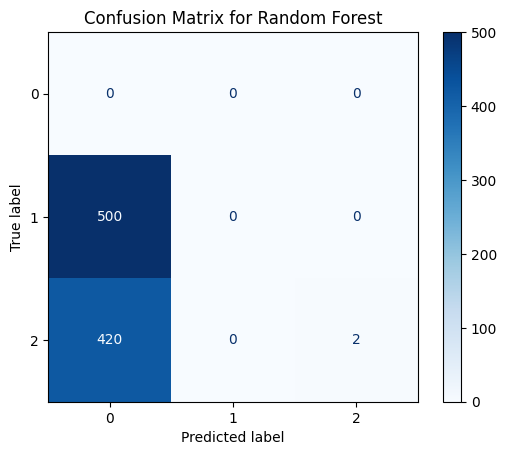

C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classifier: Logistic Regression
**************************************************
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.0000    0.0000    0.0000       500
           2     0.0231    0.0095    0.0134       422

    accuracy                         0.0043       922
   macro avg     0.0077    0.0032    0.0045       922
weighted avg     0.0106    0.0043    0.0062       922



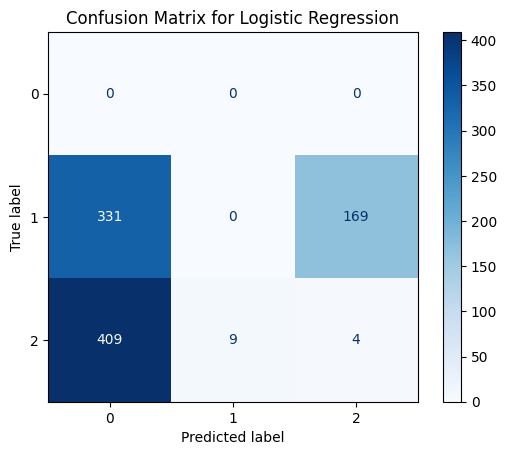


Classifier: SVM
**************************************************


C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000    0.0140    0.0276       500
           2     0.0000    0.0000    0.0000       422

    accuracy                         0.0076       922
   macro avg     0.3333    0.0047    0.0092       922
weighted avg     0.5423    0.0076    0.0150       922



C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.co

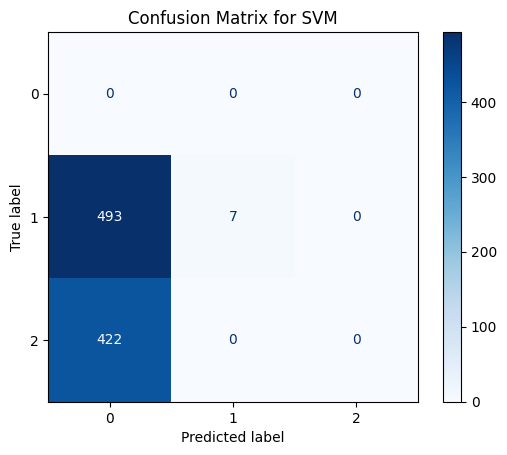


Classifier: KNN
**************************************************


C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.8431    0.0860    0.1561       500
           2     0.8889    0.0569    0.1069       422

    accuracy                         0.0727       922
   macro avg     0.5773    0.0476    0.0877       922
weighted avg     0.8641    0.0727    0.1336       922



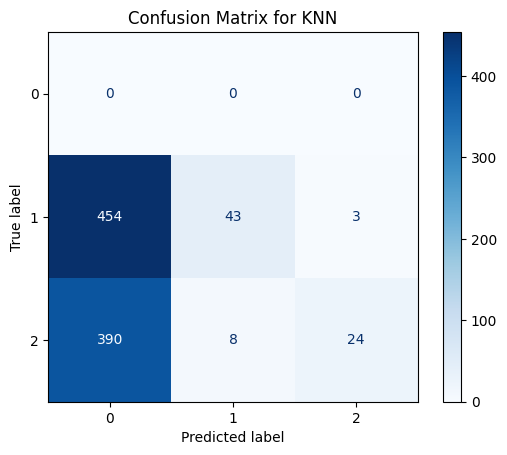


Classifier: Decision Tree
**************************************************
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.6133    0.4980    0.5497       500
           2     0.9855    0.4834    0.6486       422

    accuracy                         0.4913       922
   macro avg     0.5329    0.3271    0.3994       922
weighted avg     0.7837    0.4913    0.5950       922



C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


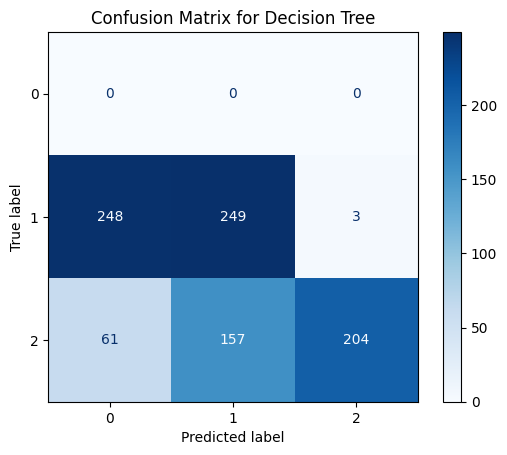

C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classifier: Gradient Boosting
**************************************************
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000    0.4940    0.6613       500
           2     0.9903    0.4834    0.6497       422

    accuracy                         0.4892       922
   macro avg     0.6634    0.3258    0.4370       922
weighted avg     0.9956    0.4892    0.6560       922



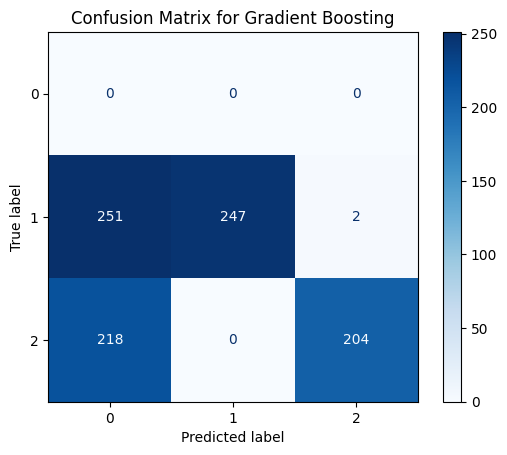


Classifier: AdaBoost
**************************************************
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.9966    0.5780    0.7316       500
           2     0.0202    0.0047    0.0077       422

    accuracy                         0.3156       922
   macro avg     0.3389    0.1942    0.2464       922
weighted avg     0.5497    0.3156    0.4003       922



C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


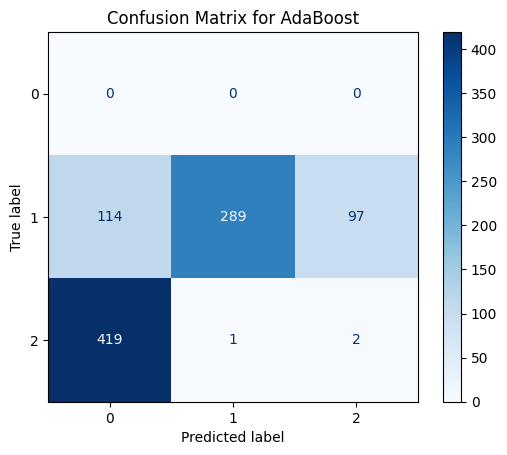


Classifier: Naive Bayes
**************************************************
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.0000    0.0000    0.0000       500
           2     0.6564    0.9597    0.7796       422

    accuracy                         0.4393       922
   macro avg     0.2188    0.3199    0.2599       922
weighted avg     0.3004    0.4393    0.3568       922



C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.co

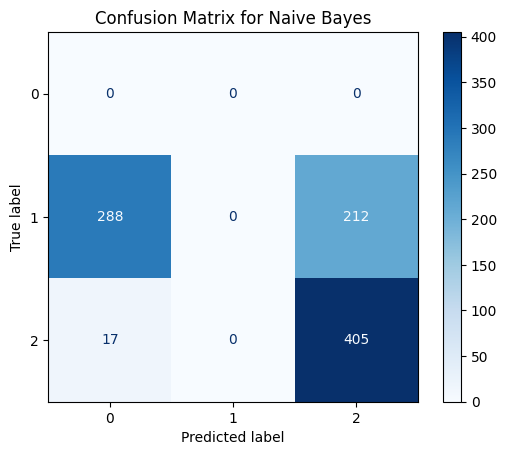

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
X = df2.drop('label', axis=1)  # Features (drop the label column)
y = df2['label']  # Labels

# List of trained classifiers with their names for easy iteration
classifiers = {
    "Random Forest": clf_flow_with_context,
    "Logistic Regression": clf_logistic,
    "SVM": clf_svc,
    "KNN": clf_knn,
    "Decision Tree": clf_tree,
    "Gradient Boosting": clf_gb,
    "AdaBoost": clf_ada,
    "Naive Bayes": clf_nb
}

# Iterate through each classifier, predict, and print results
for name, clf in classifiers.items():
    print(f"\nClassifier: {name}")
    print("*"*50)
    
    # Predict on the test set
    y_pred = clf.predict(X)
    
    # Evaluate the model
    report = classification_report(y, y_pred, digits=4)
    cm = confusion_matrix(y, y_pred)
    
    # Print classification report
    print("Classification Report:")
    print(report)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name}')
    plt.show()


Accuracy: 0.00
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.01      0.01      0.01       500
           2       0.00      0.00      0.00       422

    accuracy                           0.00       922
   macro avg       0.00      0.00      0.00       922
weighted avg       0.00      0.00      0.00       922

Confusion Matrix:
[[  0   0   0]
 [497   3   0]
 [  2 420   0]]


C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.co

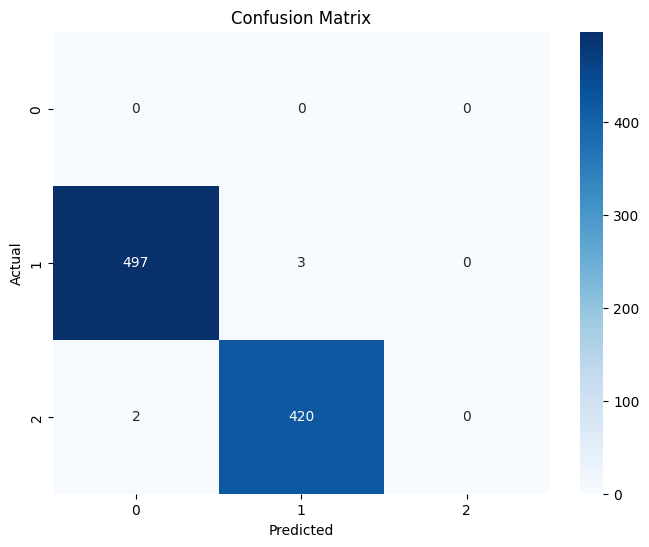

In [23]:
# X are the features and y is the target (label)
X = df2.drop('label', axis=1).values  # Drop the label column to get features
y = df2['label'].values  # String labels

y_encoded = label_encoder.transform(y)  # Converts strings to integers

X_test = scaler.transform(X)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_encoded, dtype=torch.long)
# Scale the test data using the already available scaler
X_test_scaled = scaler.transform(X_test)

# Convert the scaled test data to a torch tensor
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)

# Evaluation
y_pred = predicted.numpy()  # Predicted labels
y_true = y_test.numpy()  # True labels

# Print accuracy, classification report, and confusion matrix
accuracy = np.mean(y_pred == y_true)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_true, y_pred, ))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(cm)

# Plot confusion matrix (if needed)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


## Adversarial Testing with 10 spoofed IP and mac addresses

We are now re-evaluating our ML-based NIDS with varying numbers of spoofed IP and MAC addresses.

In [24]:
df2=pd.read_csv('C:\\Users\\syedwali\\Downloads\\adversarial\\Attacks\\Distributed\\distributed_10.csv')
target_instances = 500
df2 = balancer(df2,target_instances)
print(df2['label'].value_counts())

C:\Users\syedwali\AppData\Local\Temp\ipykernel_32524\1501981111.py:1: DtypeWarning: Columns (81,83,85) have mixed types. Specify dtype option on import or set low_memory=False.
  df2=pd.read_csv('C:\\Users\\syedwali\\Downloads\\adversarial\\Attacks\\Distributed\\distributed_5.csv')


label
dos_syn      500
ddos_icmp    423
Name: count, dtype: int64


In [25]:
#df2=df2[df2['label']=='dos_syn']
df2['label'] = df2['label'].map({'benign': 0, 'dos_syn': 1,'ddos_icmp':2})

In [26]:
df2.drop(['id','expiration_id','src_ip','src_mac','src_oui','src_port','dst_ip','dst_mac','dst_oui','dst_port',
'protocol','ip_version','vlan_id','tunnel_id','bidirectional_first_seen_ms','bidirectional_last_seen_ms','src2dst_first_seen_ms',
         'src2dst_last_seen_ms','dst2src_first_seen_ms','dst2src_last_seen_ms','application_name',
'application_category_name','application_is_guessed','application_confidence','requested_server_name','client_fingerprint',
'server_fingerprint','user_agent','content_type','udps.payload_data','udps.delta_time','udps.packet_direction','udps.ip_size',
'udps.transport_size','udps.payload_size','udps.syn','udps.cwr','udps.ece','udps.urg','udps.ack','udps.psh','udps.rst','udps.fin','file'],
        axis=1,inplace=True)
df2.dropna(inplace=True)




Classifier: Random Forest
**************************************************
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.0000    0.0000    0.0000       500
           2     1.0000    0.0071    0.0141       423

    accuracy                         0.0033       923
   macro avg     0.3333    0.0024    0.0047       923
weighted avg     0.4583    0.0033    0.0065       923



C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.co

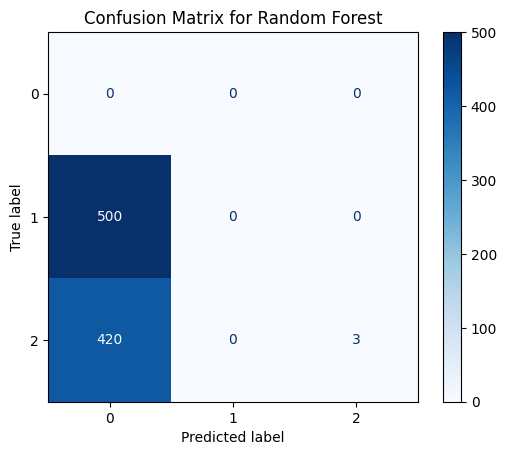


Classifier: Logistic Regression
**************************************************
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.0000    0.0000    0.0000       500
           2     0.0193    0.0095    0.0127       423

    accuracy                         0.0043       923
   macro avg     0.0064    0.0032    0.0042       923
weighted avg     0.0089    0.0043    0.0058       923



C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


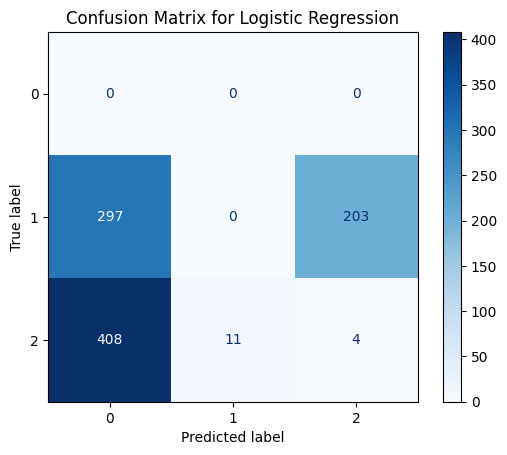


Classifier: SVM
**************************************************
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       0.0
           1     0.0000    0.0000    0.0000     500.0
           2     0.0000    0.0000    0.0000     423.0

    accuracy                         0.0000     923.0
   macro avg     0.0000    0.0000    0.0000     923.0
weighted avg     0.0000    0.0000    0.0000     923.0



C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.co

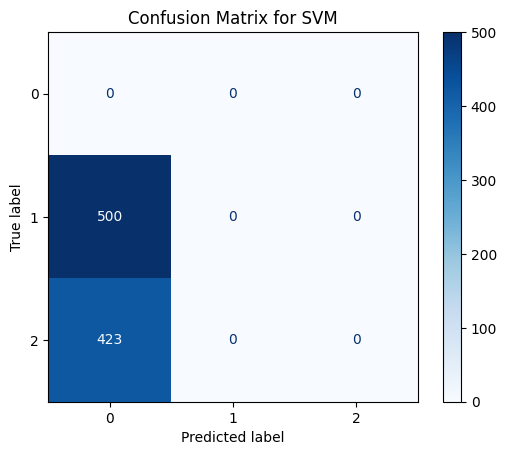


Classifier: KNN
**************************************************


C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.8824    0.0300    0.0580       500
           2     0.9720    0.2459    0.3925       423

    accuracy                         0.1289       923
   macro avg     0.6181    0.0920    0.1502       923
weighted avg     0.9234    0.1289    0.2113       923



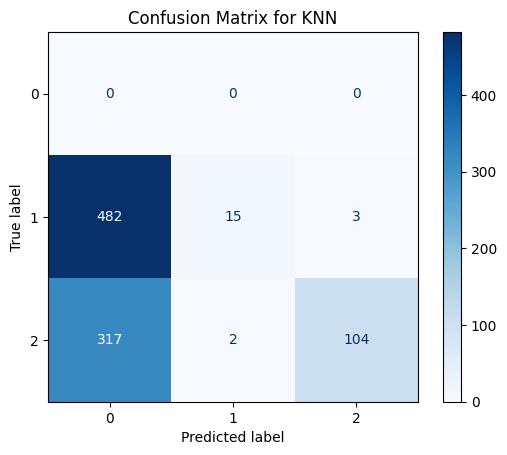


Classifier: Decision Tree
**************************************************
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.5933    0.4580    0.5169       500
           2     0.9951    0.4846    0.6518       423

    accuracy                         0.4702       923
   macro avg     0.5295    0.3142    0.3896       923
weighted avg     0.7774    0.4702    0.5788       923



C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


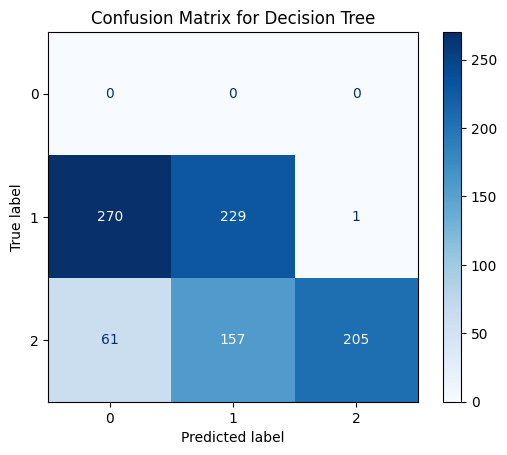

C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classifier: Gradient Boosting
**************************************************
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000    0.4560    0.6264       500
           2     0.9951    0.4846    0.6518       423

    accuracy                         0.4691       923
   macro avg     0.6650    0.3135    0.4261       923
weighted avg     0.9978    0.4691    0.6380       923



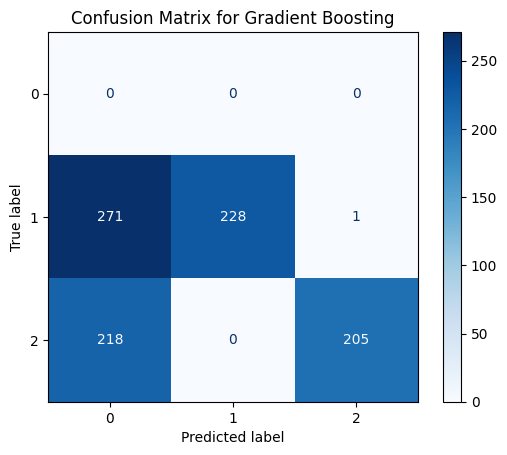


Classifier: AdaBoost
**************************************************
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.9963    0.5440    0.7038       500
           2     0.1287    0.0307    0.0496       423

    accuracy                         0.3088       923
   macro avg     0.3750    0.1916    0.2511       923
weighted avg     0.5987    0.3088    0.4040       923



C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


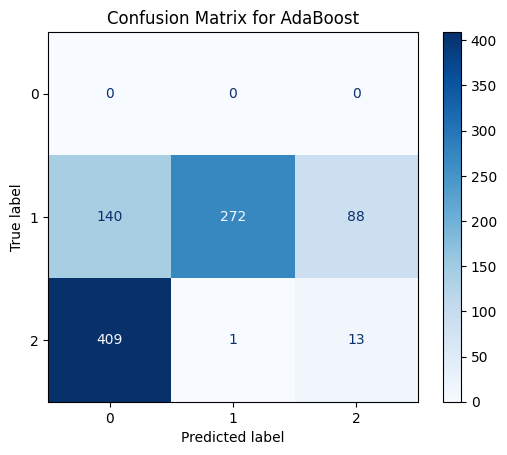


Classifier: Naive Bayes
**************************************************
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.0000    0.0000    0.0000       500
           2     0.6415    0.9645    0.7705       423

    accuracy                         0.4420       923
   macro avg     0.2138    0.3215    0.2568       923
weighted avg     0.2940    0.4420    0.3531       923



C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.co

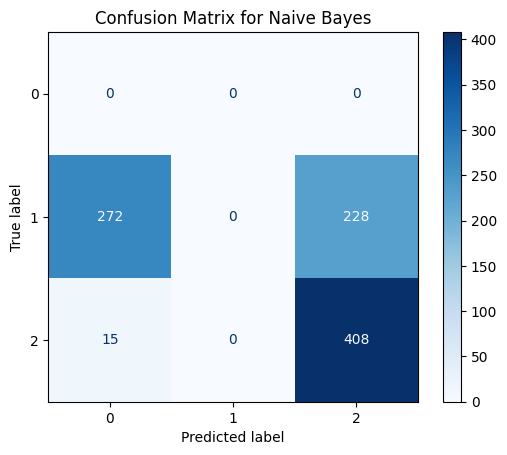

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
X = df2.drop('label', axis=1)  # Features (drop the label column)
y = df2['label']  # Labels

# List of trained classifiers with their names for easy iteration
classifiers = {
    "Random Forest": clf_flow_with_context,
    "Logistic Regression": clf_logistic,
    "SVM": clf_svc,
    "KNN": clf_knn,
    "Decision Tree": clf_tree,
    "Gradient Boosting": clf_gb,
    "AdaBoost": clf_ada,
    "Naive Bayes": clf_nb
}

# Iterate through each classifier, predict, and print results
for name, clf in classifiers.items():
    print(f"\nClassifier: {name}")
    print("*"*50)
    
    # Predict on the test set
    y_pred = clf.predict(X)
    
    # Evaluate the model
    report = classification_report(y, y_pred, digits=4)
    cm = confusion_matrix(y, y_pred)
    
    # Print classification report
    print("Classification Report:")
    print(report)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name}')
    plt.show()


Accuracy: 0.00
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00       500
           2       0.00      0.00      0.00       423

    accuracy                           0.00       923
   macro avg       0.00      0.00      0.00       923
weighted avg       0.00      0.00      0.00       923

Confusion Matrix:
[[  0   0   0]
 [499   1   0]
 [  1 422   0]]


C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.co

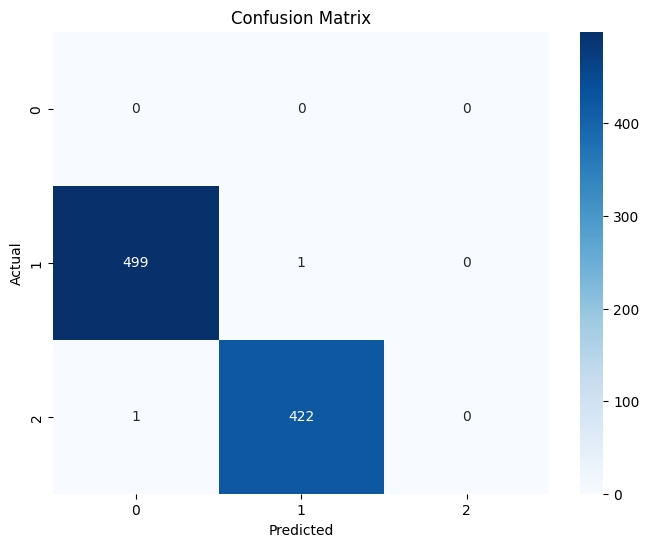

In [28]:
# X are the features and y is the target (label)
X = df2.drop('label', axis=1).values  # Drop the label column to get features
y = df2['label'].values  # String labels

y_encoded = label_encoder.transform(y)  # Converts strings to integers

X_test = scaler.transform(X)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_encoded, dtype=torch.long)
# Scale the test data using the already available scaler
X_test_scaled = scaler.transform(X_test)

# Convert the scaled test data to a torch tensor
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)

# Evaluation
y_pred = predicted.numpy()  # Predicted labels
y_true = y_test.numpy()  # True labels

# Print accuracy, classification report, and confusion matrix
accuracy = np.mean(y_pred == y_true)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_true, y_pred, ))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(cm)

# Plot confusion matrix (if needed)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
